In [3]:
import numpy as np
import pandas as pd
import math
import os
import sys
import glob
import time
import pickle
import h5py
import itertools
import altair as alt
alt.data_transformers.disable_max_rows()

from astropy import units as u
from astropy.timeseries import LombScargle

from scipy.spatial.distance import euclidean

from sklearn.preprocessing import MinMaxScaler

from dtaidistance import dtw, clustering
from dtaidistance import dtw_visualisation as dtwvis

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

import multiprocessing as mp
from multiprocessing import Pool
print("Number of processors: ", mp.cpu_count())

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

Number of processors:  96


In [4]:
ff = h5py.File(f'{tb.cat_dir}/asassn_tess_inspected.hdf5', mode="r")

df = {}
for key in list(ff):
    if key == 'type':
        df[key] = np.array(ff[key].value, dtype='str')
    else:
        df[key] = ff[key].value
    
ff.close()
sample = pd.DataFrame(data=df)

/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [10]:
ls_period, bls_period = [], []
full_df = []
for ID in list(sample['tic_id']):
    infile = open(f'{tb.ps_dir}/{ID}_ps.pkl','rb')
    ps_dict = pickle.load(infile)
    infile.close()
    ls_period.append(ps_dict['ls_best_period'])
    bls_period.append(ps_dict['bls_best_period'])
    full_df.append(ps_dict['data'])
sample['ls_period']  = np.array(ls_period)
sample['bls_period'] = np.array(bls_period)
# sample['dataframes'] = full_df

In [46]:
def preprocessData(dataframe, period, tsteps=100):
    
    pharr = np.linspace(0,1,tsteps)
    
    phase_fold_df = dataframe.fold(period=period*u.day)
    binned_flux = tb.binData(phase_fold_df, tsteps)
    shift_flux = np.roll(np.array(binned_flux), tsteps-np.argmin(binned_flux))

    scaler = MinMaxScaler()
    phase_flux_array = np.vstack([pharr, shift_flux]).T
    scaler.fit(phase_flux_array)
    scaled_flux = scaler.transform(phase_flux_array).T[1]

    return scaled_flux

def plotDTW(flux1, flux2, **kwargs):
    
    types = kwargs.get('types', ['Source 1', 'Source 2'])
    tsteps = len(flux1)
    pharr = np.linspace(0,1,tsteps)
    
    d, paths = dtw.warping_paths(flux1, flux2, window=5, psi=2)
    matches = dtw.best_path(paths)

    plt.figure(figsize=[16,8])
    plt.plot(pharr, flux1, label=types[0])
    plt.plot(pharr, flux2, label=types[1])

    for m in matches:
        plt.plot((pharr[m[0]], pharr[m[1]]), (flux1[m[0]], flux2[m[1]]), color='k')
    plt.title(f'DTW Distance: {str(np.round(d,3))}', fontsize=18)
    plt.legend(loc='lower right', fontsize=16)
    plt.ticklabel_format(useOffset=False)
    plt.show()

/astro/users/jbirky/.local/lib/python3.6/site-packages/dtaidistance/dtw.py:302: RuntimeWarning: invalid value encountered in sqrt
  dtw = np.sqrt(dtw)


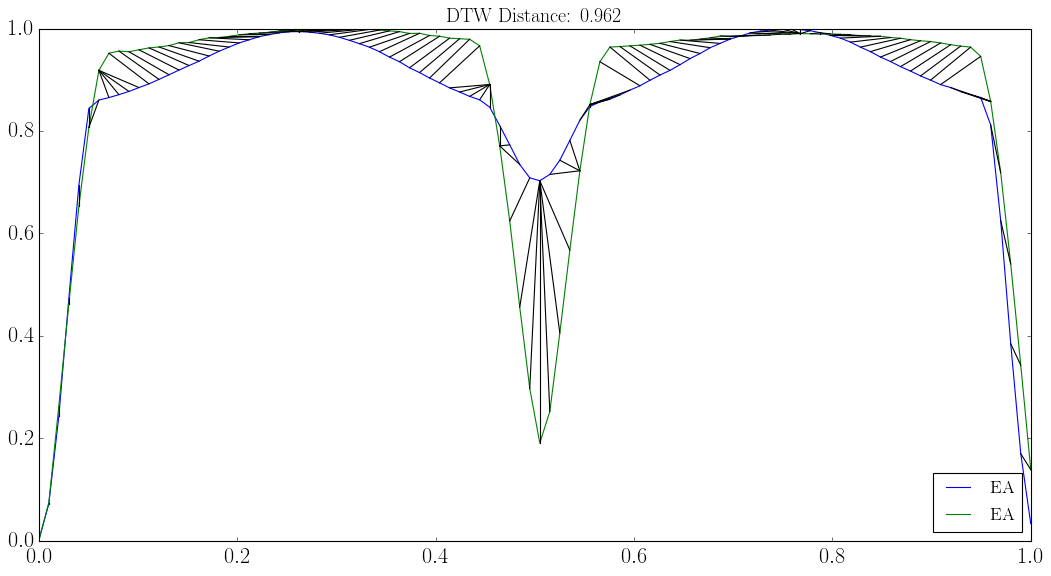

In [55]:
i, j = 2, 4

flux1 = preprocessData(full_df[i], sample['period'][i])
flux2 = preprocessData(full_df[j], sample['period'][j])

plotDTW(flux1, flux2, types=[sample['type'][i], sample['type'][j]])